In [35]:
#IMPPORT 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import animation
import warnings
warnings.filterwarnings('ignore')
import math 
import numpy as np
import matplotlib.cm as cm
from collections import deque
%matplotlib inline
from scipy import stats
from decimal import *
import random 
import scipy as sp
import collections
import heapq 
import seaborn as sns
sns.set()
sns.set(style = "ticks",palette = "pastel")
from copy import deepcopy
import matplotlib.patches as mpatches

In [36]:


def rij(i,j):
    r = (i.x[0] -j.x[0])**2 + (i.x[1] - j.x[1])**2
    return r

# veloctiy diff
def vij(i,j):
    v = (i.v[0] -j.v[0])**2 + (i.v[1] - j.v[1])**2
    return v

# inner product of r and v
def rv_ip(i,j):
    ip = np.dot(i.x-j.x, i.v-j.v)
    
    return ip

# expected time of collision of particle i and j 
def collision_particle(i,j):
    rv = rv_ip(i,j)
    r2 = rij(i,j)
    v2 = vij(i,j)
    dt = (r2 - (i.radius + j.radius)**2)/(-rv + np.sqrt(rv**2- v2*(r2 - (i.radius + j.radius)**2)))
    if np.isnan(dt): 
        return 10000
    return dt


# expected time of collision between particle and wall 
def collision_wall(i, R): 
    xv = np.dot(i.x, i.v)
    x2 = i.x[0]**2 + i.x[1]**2
    v2 = i.v[0]**2 + i.v[1]**2
    dt = (-xv + np.sqrt(xv**2 + v2*((R-i.radius)**2 - x2)))/v2
    if np.isnan(dt): 
        return 10000
    return dt

def update_pos(i, dti, index):
    
    global xs
    current_x = i.x
    #storage
    ts = np.arange(0, dti, 0.01)
    for t in ts:
        xs[index].append(current_x + t*i.v)
        
    i.x = i.x + dti*i.v   
    return 

# update position of i and j after collision
def update_velocity(i,j):
    
    if j is None: # collision with wall
        i.v = i.v - (2/(R-i.radius)**2) * np.dot(i.x,i.v)*i.x
        
    else: # collision with each other
        rhat = (i.x - j.x)/(i.radius + j.radius)
        vhat = i.v-j.v
        Mij = 2/(1/i.mass + 1/j.mass)
        Pij = Mij*np.dot(rhat, vhat)*rhat
        i.v= i.v - Pij/i.mass
        j.v = j.v + Pij/j.mass

    return 

In [38]:
# initial setups 

# puts atoms in a circle spaced like a square
def init_disk_square(R,N):
    atoms = []
    per_side = int(np.ceil(np.sqrt(N)))
    len_square = int(np.sqrt(2)*R)
    r = 2
    grid = np.linspace(-len_square/2+r, len_square/2-r, per_side)
    i=0
    j=0
    k =0 
    
    while i < N:
        if k == per_side:
            k =0 
            j = j+ 1
        x = grid[j]
        y = grid[k]
        #vx = float(random.randrange(-20,20)) # random initial v
        vx = float(np.sign(x)*(random.randrange(10,20)))
        #vy = float(random.randrange(-20,20)) 
        vy = float(np.sign(y)*(random.randrange(10,20)) )
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
        k = k+1
        
    return atoms

def init_billiards(R,N):
    
    atoms = []
    per_side = int(np.ceil(np.sqrt(N-1)))
    len_square = int(np.sqrt(2)*R)
    r = 2
    grid1 = np.linspace(-len_square/2+r, len_square/2-r, per_side)
    grid2 = np.linspace(0 , len_square/2-r, per_side)
    i=0
    j=0
    k =0 
    
    while i < N-1:
        if k == per_side:
            k =0 
            j = j+ 1
        x = grid1[j]
        y = grid2[k]
        vx = 0 # random initial v
        vy = 0
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
        k = k+1
    
    atom_i = Atom(0,-R/2,-10,500,r,1)
    atoms.append(atom_i)
    
    return atoms
    
def init_disk_2lines(R,N):
    atoms = []
    half = int(N/2)
    #LHS:
    L_pos_x = -int(R/2)
    R_pos_x = int(R/2)
    side_len = R*np.sqrt(3)/2
    r = 2
    grid = np.linspace(-side_len +2*r, side_len-2*r, half)
    i=0
    while i < half:
        x = L_pos_x
        y = grid[i]
        vx = 50 # fixed
        vy = 0
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
    i=0    
    while i < half:
        x = R_pos_x
        y = grid[i]
        vx = -50 # fixed
        vy = 0
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1  
    return atoms



In [39]:
class Atom:

    def __init__(atom, x, y, vx, vy, radius, mass):
        
        atom.x = np.array((x, y))
        atom.v = np.array((vx, vy))
        atom.radius = radius
        atom.mass = mass

# Event

In [40]:
def hist_vel(N, c):
    #init = [np.sqrt(v_init[i][0]**2 + v_init[i][1]**2) for i in range(N)]
    #print(sum(init))
    fig = plt.figure()
    final = [np.sqrt(atoms[i].v[0]**2 +atoms[i].v[1]**2)  for i in range(N)]
    #print(sum(final))
    a = math.ceil((np.max(final) - np.min(final))/1)
    plt.hist(final, bins = a, color = 'm')
    plt.xlim(-10,30)
    plt.xlabel('Velocity')
    plt.ylabel('Frequency')
    fig.savefig('oneatomtemp_%d.png'%(c+1), bbox_inches='tight', dpi = 800)
    
def hist_energy(N,c):
    final = [atoms[i].mass*(atoms[i].v[0]**2 +atoms[i].v[1]**2)/2 for i in range(N)]
    fig = plt.figure()
    #print(sum(final))
    a = math.ceil((np.max(final) - np.min(final))/1)
    plt.hist(final, bins = a, color = 'c')
    plt.xlim(-10,70)
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    fig.savefig('oneatomenegy_%d.png'%(c+1), bbox_inches='tight', dpi = 800)

In [41]:
def simulate_collision(R,N,C,atoms):
    global xs
    tracking = []
    xs = [[atoms[i].x] for i in range(N)]
    #hist_print = [100,1000,2000,5000,6000]
    heap_list = []
    L = [-1 for i in range(N)]# storage of collision times per particle
    tau = 0 #time of last collision
    for i in range(N):
        for j in range(i+1, N):
            # estimate collision time 
            t_star = collision_particle(atoms[i], atoms[j]) + tau
            heap_list.append((t_star, tau, i, j))
        # estimate wall collision time 
        t_star = collision_wall(atoms[i],R) + tau
        heap_list.append((t_star, tau, i, -1))
    heapq.heapify(heap_list) 
    
    #hist_vel(N,0)
    #hist_energy(N,0)
    
    for c in range(C):
        invalid = 1
        while invalid:

            col = heapq.heappop(heap_list)

            if col[0] < col[1] or col[1] < (L[col[2]]- 1e-12) or (col[1] < (L[col[3]]- 1e-12) and col[3]!= -1):
                invalid = 1 
            else:
                invalid = 0

        for i in range(N):
            update_pos(atoms[i], col[0] - tau, i)  

        tau = col[0] # update time to current collision time
        tracking.append(col)
        if col[3] == -1: # collision with wall
            i = col[2]
            L[i] = tau
            update_velocity(atoms[i], None)
            for j in range(N):
                if j!= i:
                    t_star = collision_particle(atoms[i], atoms[j]) + tau
                    heapq.heappush(heap_list,(t_star, tau, i, j))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, col[2], -1))

        else: #collision with other particle
            i = col[2]
            j = col[3]
            L[i] = tau
            L[j] = tau
            update_velocity(atoms[i],atoms[j])
            for a in range(N):
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[i], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[2], a))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, i, -1))

            for a in range(N): 
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[j], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[3], a))
            t_star = collision_wall(atoms[j],R) + tau
            heapq.heappush(heap_list, (t_star, tau, j, -1))   
            
        #if c+1 in hist_print:
            #hist_vel(N,c)
            #hist_energy(N,c)
    return tau

In [379]:
R = 200
N= 401
C = 6000
atoms = init_billiards(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]

energy_init = 0
for i in range(N):
    energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 

print(energy_init)
simulate_collision(R,N,C,atoms)

energy_final = 0
for i in range(N):
    energy_final = energy_final + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
print('Energy lost: %.10f' %(energy_init-energy_final))     



125050.0
Energy lost: -0.0000000326


Text(0, 0.5, 'Frequency')

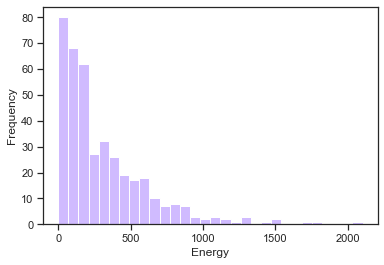

In [417]:
final = [atoms[i].mass*(atoms[i].v[0]**2 +atoms[i].v[1]**2)/2 for i in range(N)]
#print(sum(final))
plt.hist(final, bins = 30, color = 'm')
plt.xlabel('Energy')
plt.ylabel('Frequency')
#plt.savefig('oneatomtemp_%d.png'%c, bbox_inches='tight', dpi = 800)

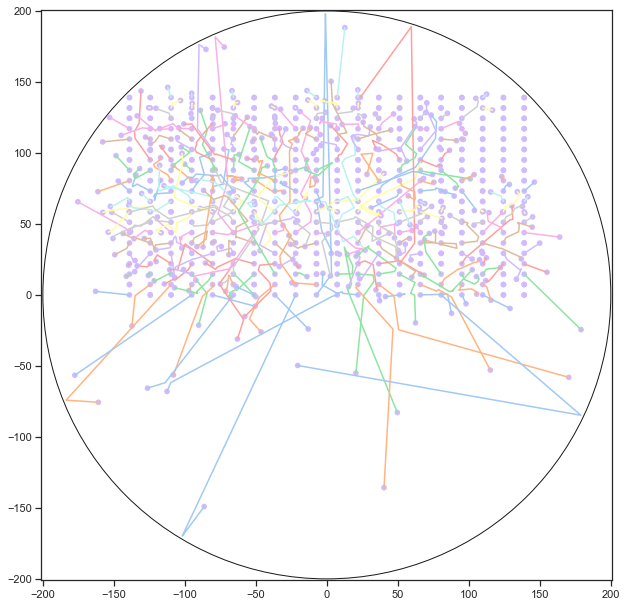

In [274]:
%matplotlib inline
xsx = np.array(xs)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_ylim(-(R+1),(R+1))
ax.set_xlim(-(R+1),(R+1))
ax.add_artist(circle1)
for i in range(N-1):
    ax.plot(xsx[i,:][:,0],xsx[i,:][:,1])    
    circle2 = plt.Circle((xsx[i][0][0], xsx[i][0][1]), 2, color='m', linewidth=0,fill = True)
    ax.add_artist(circle2)
    circle3= plt.Circle((xsx[i][-1][0], xsx[i][-1][1]), 2, color='m', linewidth=0, fill = True)
    ax.add_artist(circle3)
ax.set_aspect(1)


Text(0, 0.5, 'Density')

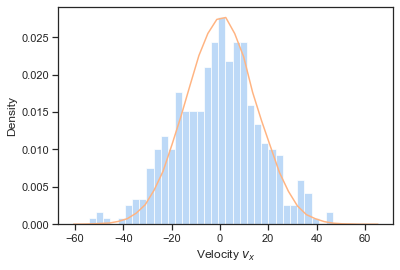

In [442]:
#final = [np.sqrt(atoms[i].v[0]**2 + atoms[i].v[1]**2) for i in range(N)]
finalx = [atoms[i].v[0] for i in range(N)]
a = math.ceil((np.max(finalx) - np.min(finalx))/3)
plt.hist(finalx, bins = a, density = True, alpha = 0.7, color = 'b')
gauss = plt.hist(np.random.normal(loc = np.mean(finalx)+3, scale =14.5, size = 100000), bins = a,alpha = 0, density = True)
plt.plot(gauss[1],np.append(gauss[0],0))
#plt.xlim(-0,70)
plt.xlabel(r'Velocity $v_x$')
plt.ylabel('Density')
#plt.savefig('vel_x.png',bbox_inches='tight', dpi = 800 )
#plt.hist(np.random.normal(loc = np.mean(final), scale = 2, size = N), bins = a, alpha = 0.6)

In [42]:
def init_disk_temp(R,N):
    atoms = []
    per_side = int(np.ceil(np.sqrt(N)))
    len_square = int(np.sqrt(2)*R)
    r = 2
    grid = np.linspace(-len_square/2+r, len_square/2-r, per_side)
    i=0
    j=0
    k =0 
    
    while i < N:
        if k == per_side:
            k =0 
            j = j+ 1
        x = grid[j]
        y = grid[k]
        #vx = float(random.randrange(-20,20)) # random initial v
        vx = np.sign(x)*20
        #vy = float(random.randrange(-20,20)) 
        vy = 0
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
        k = k+1
        
    return atoms

In [50]:
R = 100
N= 225
C = 6000
atoms = init_disk_temp(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]

energy_init = 0
for i in range(N):
    energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 

print(energy_init)
simulate_collision(R,N,C,atoms)

energy_final = 0
for i in range(N):
    energy_final = energy_final + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
print('Energy lost: %.10f' %(energy_init-energy_final))     



42000.0
Energy lost: -2492.6272867146


(array([23., 51., 47., 46., 26., 19.,  9.,  3.,  0.,  1.]),
 array([ 1.38306068,  6.79367475, 12.20428882, 17.61490288, 23.02551695,
        28.43613102, 33.84674509, 39.25735916, 44.66797323, 50.0785873 ,
        55.48920136]),
 <a list of 10 Patch objects>)

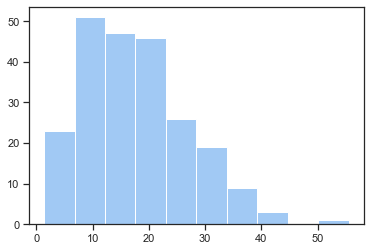

In [54]:
v = [np.sqrt(atoms[i].v[0]**2 +atoms[i].v[1]**2)   for i in range(N)]
plt.hist(v)

# Pressure 

In [16]:
def momentum(i):
    P = np.abs((2/(R-i.radius)**2) * np.dot(i.x,i.v)*i.x)
    return P

def init_circle_out(R,N):
    atoms = []
    r = 2
    grid = np.linspace(0, 2*np.pi - 0.2, N)
    i=0

    
    while i < N:
        x = (R-r-2)*np.cos(grid[i])
        y = (R-r-2)*np.sin(grid[i])
        if grid[i] <=np.pi/2:
            signx = 1
            signy = 1
        if grid[i] > np.pi/2 and grid[i]<= np.pi:
            signx = -1
            signy = 1
        if grid[i] > np.pi and grid[i]<= 3*np.pi/2:
            signx = -1
            signy =-1
        if grid[i] > 3*np.pi/2 and grid[i]<= 2*np.pi:
            signx = 1
            signy = -1
        vx = signx*20
        vy = signy*20
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+1
        
    return atoms

In [17]:
def simulate_time(R,N,T,atoms):
    global xs
    tracking = []
    xs = [[atoms[i].x] for i in range(N)]

    heap_list = []
    L = [-1 for i in range(N)]# storage of collision times per particle
    force_list = []
    
    tau = 0 #time of last collision
    for i in range(N):
        for j in range(i+1, N):
            # estimate collision time 
            t_star = collision_particle(atoms[i], atoms[j]) + tau
            heap_list.append((t_star, tau, i, j))
        # estimate wall collision time 
        t_star = collision_wall(atoms[i],R) + tau
        heap_list.append((t_star, tau, i, -1))
    heapq.heapify(heap_list) 

    while 1:
        invalid = 1
        while invalid:

            col = heapq.heappop(heap_list)

            if col[0] < col[1] or col[1] < (L[col[2]]- 1e-12) or (col[1] < (L[col[3]]- 1e-12) and col[3]!= -1):
                invalid = 1 
            else:
                invalid = 0
        
        if col[0] >=T:
            for i in range(N):
                update_pos(atoms[i],T - tau, i)  
            break
            
        for i in range(N):
            update_pos(atoms[i], col[0] - tau, i)  

        tau = col[0] # update time to current collision time
        tracking.append(col)
        if col[3] == -1: # collision with wall
            i = col[2]
            L[i] = tau
            f = momentum(atoms[i])
            force_list.append(f)
            update_velocity(atoms[i], None)
            for j in range(N):
                if j!= i:
                    t_star = collision_particle(atoms[i], atoms[j]) + tau
                    heapq.heappush(heap_list,(t_star, tau, i, j))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, col[2], -1))

        else: #collision with other particle
            i = col[2]
            j = col[3]
            L[i] = tau
            L[j] = tau
            update_velocity(atoms[i],atoms[j])
            for a in range(N):
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[i], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[2], a))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, i, -1))

            for a in range(N): 
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[j], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[3], a))
            t_star = collision_wall(atoms[j],R) + tau
            heapq.heappush(heap_list, (t_star, tau, j, -1))      
    return force_list

In [18]:
R =100
Ns= [100,225, 400,625]
T= 2
Pa_list = []
Es = []
for N in Ns:
    print(N)
    atoms = init_disk_square(R,N)
    v_init = [atoms[i].v for i in range(N)]
    x_start =  [atoms[i].x for i in range(N)]
    energy_init = 0
    for i in range(N):
        energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    Es.append(energy_init)
    #run to equilibrium 
    f_list = simulate_time(R,N,T,atoms)
    # force over 1 second 
    f_list = simulate_time(R,N,1,atoms)
    F =f_list
    A= 2*np.pi*R
    f_A = [F[i]/A for i in range(len(F))]
    F_x = [f_A[i][0] for i in range(len(F))]
    F_x_mean = np.sum(F_x)
    F_y = [f_A[i][1] for i in range(len(F))]
    F_y_mean = np.sum(F_y)

    Pa = (F_x_mean+F_y_mean)/2
    Pa_list.append(Pa)

100
225
400
625


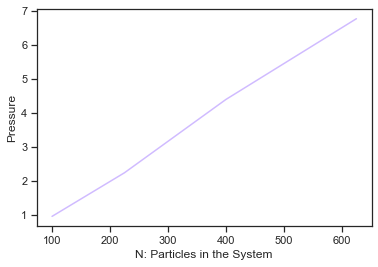

In [19]:
plt.plot(Ns,Pa_list, 'm')
plt.xlabel('N: Particles in the System')
plt.ylabel(r'Pressure')
plt.savefig('PAvN.png',bbox_inches='tight', dpi = 800 )

In [28]:
def init_square_v_control(R,N,v):
    atoms = []
    per_side = int(np.ceil(np.sqrt(N)))
    len_square = int(np.sqrt(2)*R)
    r = 2
    grid = np.linspace(-len_square/2+r, len_square/2-r, per_side)
    i=0
    j=0
    k =0 
    
    while i < N:
        if k == per_side:
            k =0 
            j = j+ 1
        x = grid[j]
        y = grid[k]
        #vx = float(random.randrange(-20,20)) # random initial v
        vx = float(np.sign(x)*(random.randrange(v-10,v)))
        #vy = float(random.randrange(-20,20)) 
        vy = float(np.sign(y)*(random.randrange(v-10,v)) )
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
        k = k+1
        
    return atoms

In [ ]:
R =100
T= 2
N = 200
Pa_list = []
Es = []
Efinal= []
vs = [10,20,30,40,50,60,70,80,90,100]
for v in vs:
    print(v)
    atoms = init_square_v_control(R,N,v)
    v_init = [atoms[i].v for i in range(N)]
    x_start =  [atoms[i].x for i in range(N)]
    energy_init = 0
    for i in range(N):
        energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    Es.append(energy_init)
    #run to equilibrium 
    f_list = simulate_time(R,N,T,atoms)
    # force over 1 second 
    f_list = simulate_time(R,N,1,atoms)
    F =f_list
    A= 2*np.pi*R
    f_A = [F[i]/A for i in range(len(F))]
    F_x = [f_A[i][0] for i in range(len(F))]
    F_x_mean = np.sum(F_x)
    F_y = [f_A[i][1] for i in range(len(F))]
    F_y_mean = np.sum(F_y)
    
    energy_init = 0
    for i in range(N):
        energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    Efinal.append(energy_init)
    
    Pa = (F_x_mean+F_y_mean)/2
    Pa_list.append(Pa)

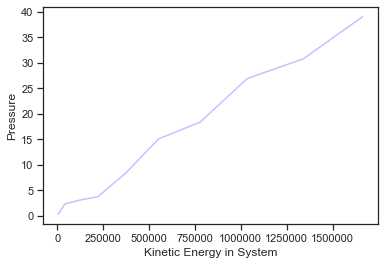

In [34]:
plt.plot(Es,Pa_list, 'm')
plt.xlabel('Kinetic Energy in System')
plt.ylabel(r'Pressure')
plt.savefig('PAvE.png',bbox_inches='tight', dpi = 800 )

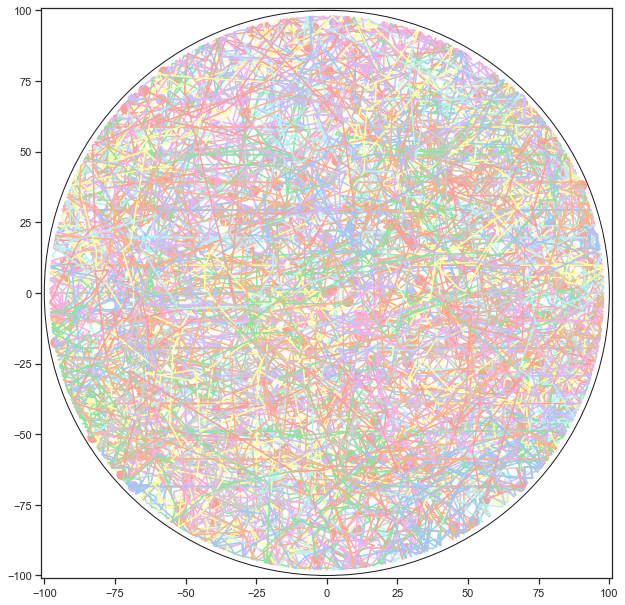

In [51]:
%matplotlib inline
xsx = np.array(xs)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_ylim(-(R+1),(R+1))
ax.set_xlim(-(R+1),(R+1))
ax.add_artist(circle1)
for i in range(N):
    ax.plot(xsx[i,:][:,0],xsx[i,:][:,1])    
    circle2 = plt.Circle((xsx[i][0][0], xsx[i][0][1]), 2, color='m', linewidth=0,fill = True)
    ax.add_artist(circle2)
    circle3= plt.Circle((xsx[i][-1][0], xsx[i][-1][1]), 2, color='r', linewidth=0, fill = True)
    ax.add_artist(circle3)
ax.set_aspect(1)


100


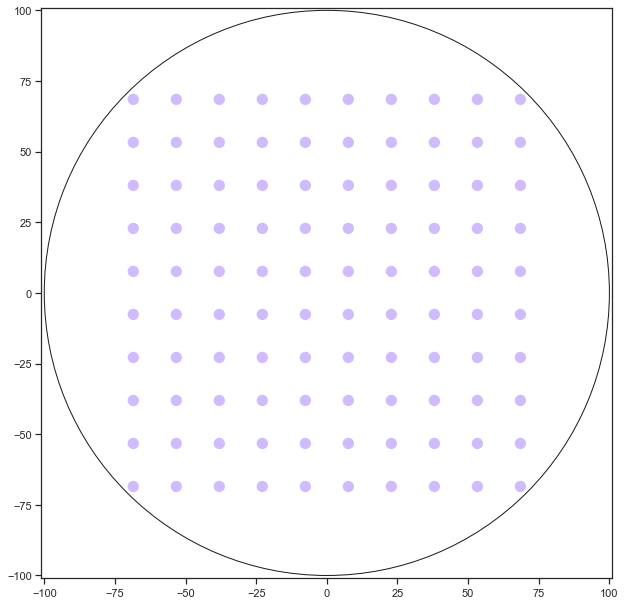

In [49]:
R = 100
N= 100
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_ylim(-(R+1),(R+1))
ax.set_xlim(-(R+1),(R+1))
ax.add_patch(circle1)
ax.set_aspect(1)

atoms = init_disk_temp(R,N)
print(len(atoms))
circles = [plt.Circle((a.x[0],a.x[1]), radius=2, linewidth=0, color = 'm') for a in atoms ]
c = matplotlib.collections.PatchCollection(circles,match_original=True)
ax.add_collection(c)
#plt.colorbar(c)

<IPython.core.display.Javascript object>


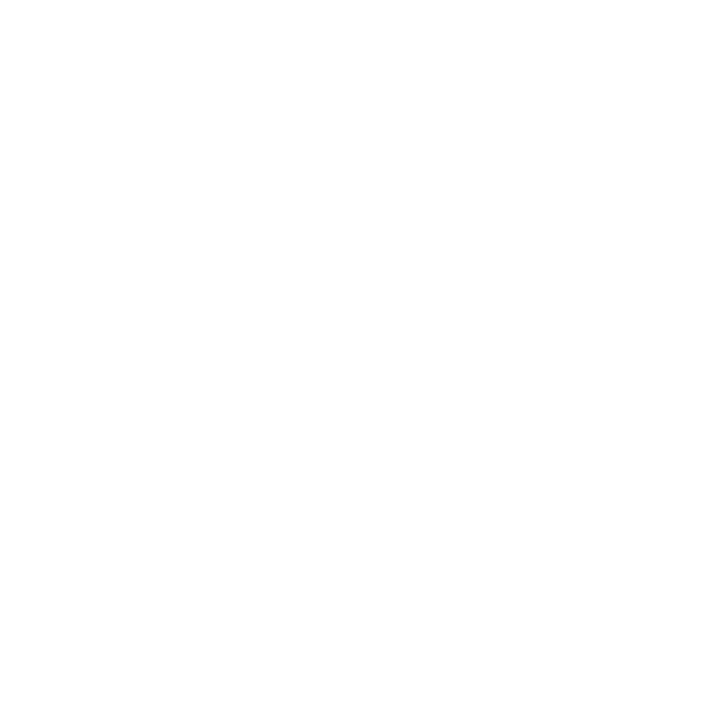

<IPython.core.display.Javascript object>


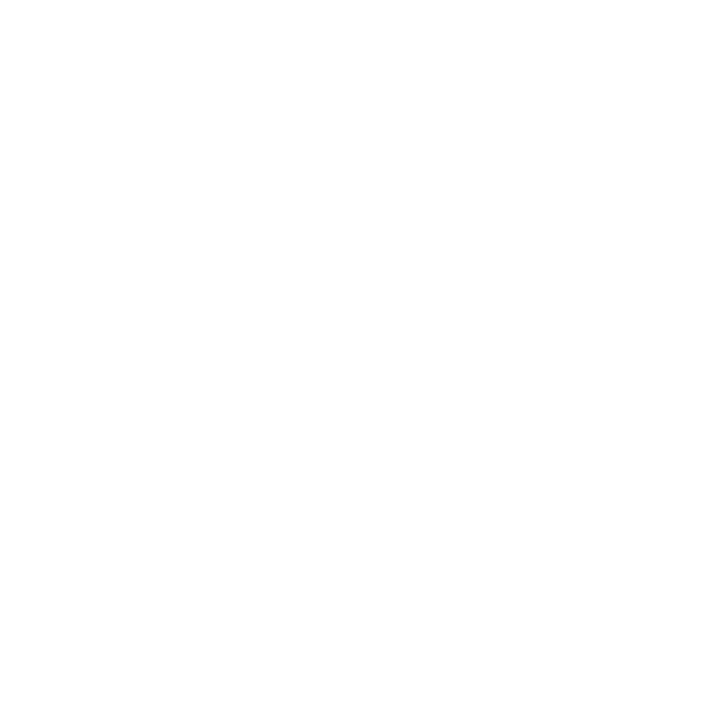

Traceback (most recent call last):
  File "C:\Users\janic\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\janic\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [694]:

%matplotlib notebook

xsx = np.array(xs)
R=100
N = 625

fig=plt.figure()
ax = plt.axes(xlim=(-(R+1),(R+1)), ylim=(-(R+1),(R+1)))
fig.set_size_inches(10, 10)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
ax.add_patch(circle1)
ax.set_aspect(1)


#ax = plt.axes(xlim=(0, 40), ylim=(0, 40))
rads = [atoms[i].radius for i in range(N)]
dict_of_circles = {}
for i in range(N):
    dict_of_circles["circle"+str(i+1)] = plt.Circle((xsx[i][0][0], xsx[i][0][1]),2,fc='b')

def init():
    for i in range(N):
        dict_of_circles["circle"+str(i+1)].center = (xsx[i][0][0], xsx[i][0][1])
        ax.add_patch(dict_of_circles["circle"+str(i+1)])
    return dict_of_circles.values()

def animate(i):
    for n in range(N):
        dict_of_circles["circle"+str(n+1)].center = (xsx[n][i][0], xsx[n][i][1])
    return dict_of_circles.values()

anim=animation.FuncAnimation(fig,animate,init_func=init,frames=len(xsx[0]),blit=True)
anim.save(
  filename='test.mp4',
  fps=30,
  dpi=200,
)

In [696]:
anim.save(
  filename='test.mp4',
  fps=300,
  dpi=200,
)